# Linear Programming Minimization Template

## Table of Contents
1. Data Entry
2. Display Problem Data
3. Build and Solve the Model
4. Display Solution Table
5. Graphed Solution (Feasible Region and Optimal Point)
6. Visualize Solution (Bar Chart)
7. Sensitivity Analysis (Shadow Prices and Reduced Costs)
8. Notes

## 1. Data Entry

**Edit only this cell to define your problem.**  
- `var_names`: List your variable names (e.g., `['x1', 'x2', 'x3']` or `['x1', 'x2', 'x3', 'x4']`)
- `objective_coefs`: Coefficients for the objective function (same order as `var_names`)
- `bounds`: Lower and upper bounds for each variable (use `None` for no upper bound)
- `constraints`: Each constraint is a tuple: (list of coefficients, sense, RHS).  
  - Senses: `'<='`, `'>='`, or `'='`
  - Coefficient lists must match the number of variables.

In [2]:
# --- DATA ENTRY ---

# Variable names
var_names = ['x1', 'x2', 'x3']

# Objective coefficients (minimize 10x1 + 12x2 + 15x3)
objective_coefs = [10, 12, 15]

# Variable bounds (lower, upper) for each variable
bounds = [(0, None)] * 3  # All variables >= 0

# Constraints: ([coefs], sense, rhs)
constraints = [
    ([2, 1, 3], '>=', 50),  # 2x1 + 1x2 + 3x3 >= 50
    ([1, 3, 1], '>=', 40),  # 1x1 + 3x2 + 1x3 >= 40
    ([3, 2, 1], '>=', 45)   # 3x1 + 2x2 + 1x3 >= 45
]

## 2. Display Problem Data

In [3]:
import pandas as pd

# Variables table
var_df = pd.DataFrame({
    'Variable': var_names,
    'Objective Coef': objective_coefs,
    'Lower Bound': [b[0] for b in bounds],
    'Upper Bound': [b[1] for b in bounds]
})
display(var_df)

# Constraints table
con_data = []
for i, (coefs, sense, rhs) in enumerate(constraints):
    row = {var_names[j]: coefs[j] for j in range(len(var_names))}
    row['Sense'] = sense
    row['RHS'] = rhs
    con_data.append(row)
con_df = pd.DataFrame(con_data)
display(con_df)

,Variable,Objective Coef,Lower Bound,Upper Bound
0,x1,10,0,None
1,x2,12,0,None
2,x3,15,0,None


,x1,x2,x3,Sense,RHS
0,2,1,3,>=,50
1,1,3,1,>=,40
2,3,2,1,>=,45


## 3. Build and Solve the Model

In [5]:
import pulp as pl

# Create the model
model = pl.LpProblem("Minimization_Problem", pl.LpMinimize)

# Create variables
vars = [pl.LpVariable(var_names[i], lowBound=bounds[i][0], upBound=bounds[i][1]) for i in range(len(var_names))]

# Add objective function
model += pl.lpSum([objective_coefs[i] * vars[i] for i in range(len(var_names))]), "Objective"

# Add constraints
for i, (coefs, sense, rhs) in enumerate(constraints):
    expr = pl.lpSum([coefs[j] * vars[j] for j in range(len(var_names))])
    if sense == '<=':
        model += (expr <= rhs, f"Constraint_{i+1}")
    elif sense == '>=':
        model += (expr >= rhs, f"Constraint_{i+1}")
    elif sense == '=':
        model += (expr == rhs, f"Constraint_{i+1}")

# Solve the model
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/aiopt/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/pl/w3z83xs50653rdq_0shjtkyh0000gn/T/ee1f7934771446dca6b596a2281e54c5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/pl/w3z83xs50653rdq_0shjtkyh0000gn/T/ee1f7934771446dca6b596a2281e54c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 21 RHS
At line 25 BOUNDS
At line 26 ENDATA
Problem MODEL has 3 rows, 3 columns and 9 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 3 (0) columns and 9 (0) elements
0  Obj 0 Primal inf 45 (3)
4  Obj 292
Optimal - objective value 292
Optimal objective 292 - 4 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



1

## 4. Display Solution Table

In [6]:
# Solution table
solution_df = pd.DataFrame({
    'Variable': var_names,
    'Optimal Value': [v.varValue for v in model.variables()]
})
display(solution_df)

print(f"Objective Value: {pl.value(model.objective):.2f}")
print(f"Status: {pl.LpStatus[model.status]}")

,Variable,Optimal Value
0,x1,22.0
1,x2,6.0
2,x3,0.0


Objective Value: 292.00
Status: Optimal


In [7]:
## 5. Graphed Solution (Feasible Region and Optimal Point)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Only works for 2 variables!
if len(var_names) == 2:
    x1 = np.linspace(0, max([rhs/coef[0] if coef[0] else 0 for coef, _, rhs in constraints])*1.2, 400)
    plt.figure(figsize=(8,6))

    # Plot each constraint
    for i, (coefs, sense, rhs) in enumerate(constraints):
        if coefs[1] != 0:
            y = (rhs - coefs[0]*x1) / coefs[1]
            plt.plot(x1, y, label=f"Constraint {i+1}: {coefs[0]}*x1 + {coefs[1]}*x2 {sense} {rhs}")
        else:
            plt.axvline(rhs/coefs[0], label=f"Constraint {i+1}: x1 = {rhs/coefs[0]}")

    # Fill feasible region (brute force grid)
    X, Y = np.meshgrid(x1, x1)
    feasible = np.ones_like(X, dtype=bool)
    for coefs, sense, rhs in constraints:
        if sense == '<=':
            feasible &= (coefs[0]*X + coefs[1]*Y <= rhs)
        elif sense == '>=':
            feasible &= (coefs[0]*X + coefs[1]*Y >= rhs)
        elif sense == '=':
            feasible &= (np.isclose(coefs[0]*X + coefs[1]*Y, rhs))
    plt.contourf(X, Y, feasible, levels=[0.5, 1], colors=['#d0f0d0'], alpha=0.5)

    # Plot optimal point
    opt_x = [v.varValue for v in model.variables()]
    plt.plot(opt_x[0], opt_x[1], 'ro', label='Optimal Solution')

    # Plot objective function line (z = optimal value)
    z = pl.value(model.objective)
    if objective_coefs[1] != 0:
        y_obj = (z - objective_coefs[0]*x1) / objective_coefs[1]
        plt.plot(x1, y_obj, 'k--', label='Objective (z)')

    plt.xlim(0, max(x1))
    plt.ylim(0, max(x1))
    plt.xlabel(var_names[0])
    plt.ylabel(var_names[1])
    plt.legend()
    plt.title('Feasible Region and Optimal Solution')
    plt.grid(True)
    plt.show()
else:
    print("Feasibility region plot is only available for 2-variable problems.")

Feasibility region plot is only available for 2-variable problems.


## 6. Visualize Solution (Bar Chart)

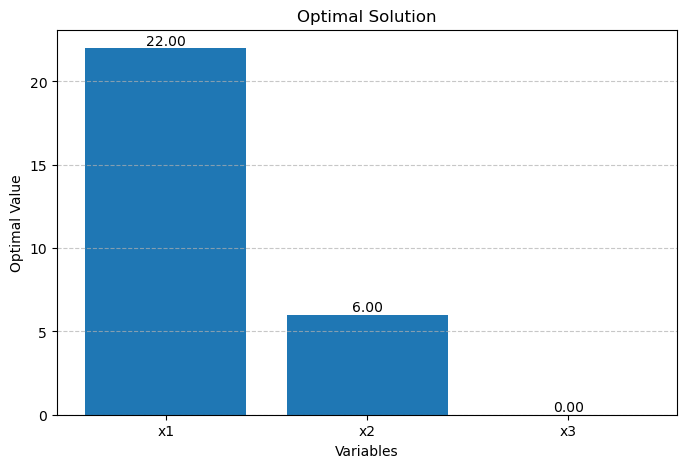

In [10]:
var_values = [v.varValue for v in model.variables()]
plt.figure(figsize=(8, 5))
bars = plt.bar(var_names, var_values)
plt.xlabel('Variables')
plt.ylabel('Optimal Value')
plt.title('Optimal Solution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

## 7. Sensitivity Analysis (Shadow Prices and Reduced Costs)

In [11]:
# Sensitivity Analysis: Shadow Prices (Dual Values) and Reduced Costs

print("Constraint Shadow Prices (Dual Values) and Slacks:")
for name, constraint in model.constraints.items():
    print(f"{name}: Shadow Price = {constraint.pi:.2f}, Slack = {constraint.slack:.2f}")

print("\nVariable Reduced Costs:")
for v in model.variables():
    print(f"{v.name}: Reduced Cost = {v.dj:.2f}")

Constraint Shadow Prices (Dual Values) and Slacks:
Constraint_1: Shadow Price = 3.60, Slack = -0.00
Constraint_2: Shadow Price = 2.80, Slack = -0.00
Constraint_3: Shadow Price = 0.00, Slack = -33.00

Variable Reduced Costs:
x1: Reduced Cost = 0.00
x2: Reduced Cost = 0.00
x3: Reduced Cost = 1.40


## 8. Notes

- To solve a 4-variable problem, just add the fourth variable and update the lists in the Data Entry cell.
- For more than 2 variables, only the bar chart is shown (feasible region plots are only practical for 2 variables).
- You can add more markdown cells to explain your specific problem or results.